In [20]:
# data preparation + loading
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision import models
from torch import optim

# neural net
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable

# general processing
from skimage import io
import matplotlib.pyplot as plt
import PIL.Image as Image

# useful tools
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [21]:
## confirm that current device is cuda compatible ##
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0) + " is ready and CUDA compatible")
else:
    print("Not CUDA compatible device")

NVIDIA GeForce RTX 3060 Ti is ready and CUDA compatible


In [22]:
### --- Create New annotated_truth label file --- ###
def create_annotated_truth():
    df = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
    df.to_csv('annotated_truth.csv')
    df['Category'] = 0
    df['image'] = df['image'] + '.jpg'
    for i in range(0, df.shape[0]):
        for j in range(1, 9):
            if df.iloc[i, j] == 1.0:
                df.iloc[i, 10] = j
    df.to_csv('annotated_truth.csv')
# create_annotated_truth()

In [23]:
### --- MelanomaDataset Class --- ###
class MelanomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])  #think this works
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 11]))
        if self.transform:
            image = self.transform(image) 
        return image, y_label

In [24]:
### --- Print first file not downloaded --- ###
def remove_missing():
    df = pd.read_csv('annotated_truth.csv')
    for i in range(len(df['image'])):
        if not os.path.exists('./data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + df['image'][i]):
            print(df['image'][i])
            break
    print('All images are present!')       
remove_missing()

All images are present!


In [25]:
### --- Create data transforms --- ###
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ## TODO - normalize to mean and std
])

In [26]:
### --- Create dataset --- ###
dataset = MelanomaDataset(csv_file='annotated_truth.csv',
                          root_dir='data/ISIC_2019_Training_Input/ISIC_2019_Training_Input',
                          transform=data_transforms)

In [27]:
### --- Print number of image labels we have --- ###
df = pd.read_csv('annotated_truth.csv')
print(len(df['image']))

25331


In [28]:
### --- Create train, test split; Create Dataloaders --- ###
train_set, test_set = torch.utils.data.random_split(dataset, [20265, 5066])
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

ak ak nv nv bcc nv nv nv nv nv bcc nv mel bkl bkl nv nv nv mel mel bcc bcc ak mel bcc nv bkl ak bkl nv mel nv 

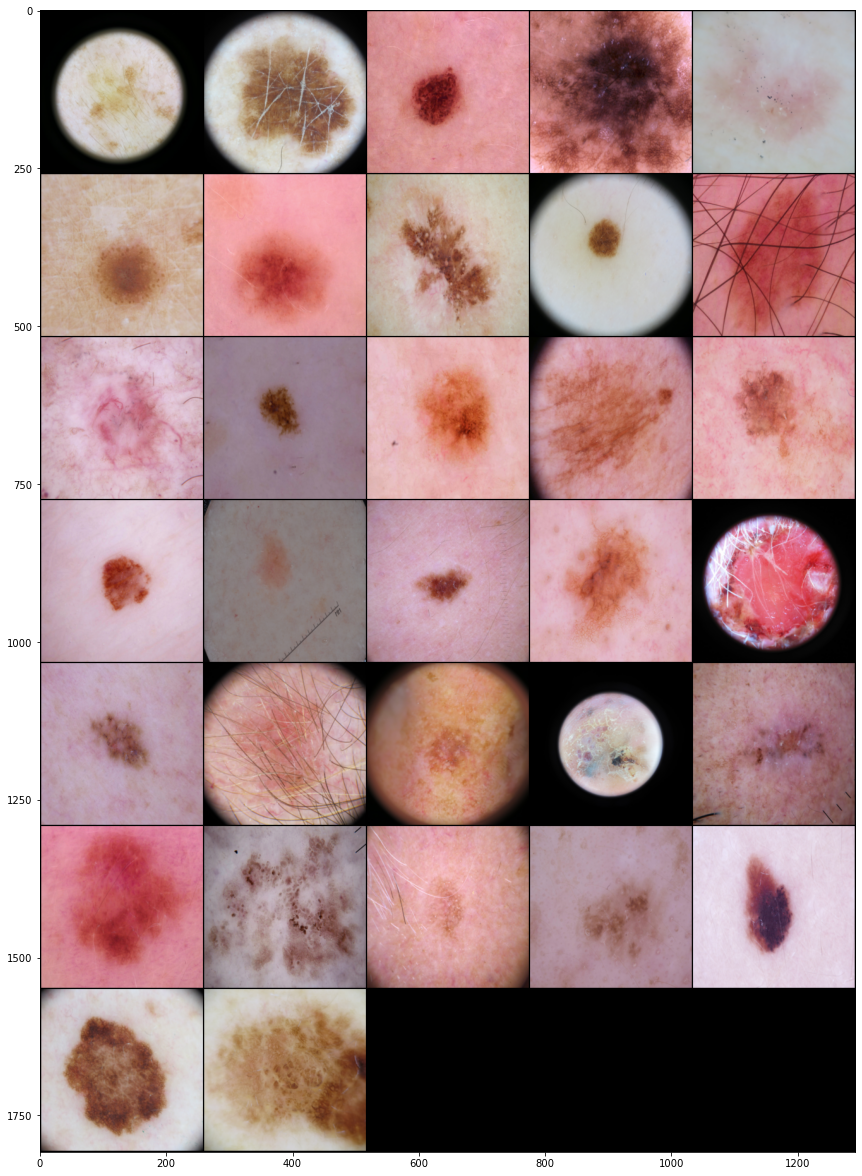

In [29]:
### --- Display labelled images in dataset --- ###

# define categories
categories = ['null', 'mel', 'nv', 'bcc', 'ak', 'bkl', 'df', 'vasc', 'scc', 'unk']

# get some random training images
dataiter = next(iter(train_loader))
images, labels = dataiter

# show images
grid = make_grid(images, nrow=5)
plt.figure(figsize=(21, 21))
plt.imshow(np.transpose(grid, (1,2,0)))
for label in labels:
    print(categories[label], end=" ")

In [35]:
# model allocation setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # set device to cuda
batch_size = 32
num_workers = 4

In [36]:
# define neural network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, padding=0, stride=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.fc1 = nn.Linear(24*14*14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9) # 9 image classes
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 24*14*14)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    

net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)


In [37]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [40]:
# define number of epochs for training
num_epochs = 8

In [42]:
for epoch in range(num_epochs):
    running_loss = 0.0 #initialize loss to be 0, floating point
    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero our parameter gradients for training
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)                 # save the output x to outputs 
        loss = criterion(outputs, labels)     # define cross entropy loss on outputs and labels
        loss.backward()                       # backpropogation
        optimizer.step()                      # step the optimizer using gradient descent
        
        
        # print statistics
        running_loss += loss.item()
        if i % 634 == 633:    # print every epoch
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished Training!')

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:18<00:54,  2.47it/s]

[1,   500] loss: 0.386


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:19<00:53,  2.52it/s]

[2,   500] loss: 0.344


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:20<00:55,  2.42it/s]

[3,   500] loss: 0.330


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:18<00:51,  2.59it/s]

[4,   500] loss: 0.324


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:17<00:51,  2.60it/s]

[5,   500] loss: 0.317


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:18<00:51,  2.58it/s]

[6,   500] loss: 0.314


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:18<00:54,  2.47it/s]

[7,   500] loss: 0.310


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 500/634 [03:18<00:54,  2.48it/s]

[8,   500] loss: 0.304


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 634/634 [04:10<00:00,  2.53it/s]

Finished Training!


In [43]:
PATH = './mel-CNN.pt'
torch.save(net.state_dict(), PATH)